# Visualizations with Plotly

In [1]:
# Imports
import numpy as np 
import pandas as pd

# Plotting 
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from category_encoders import OneHotEncoder

In [2]:
# Load Data
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Remove rows with missing target, set Id as index
#train.dropna(axis=0, subset=['SalePrice'], inplace=True)
train.set_index('Id', inplace = True)
test.set_index('Id', inplace = True)

# Preprocessing

If you want more detail about these preprocessing steps see [my notebook](https://www.kaggle.com/rsizem2/house-prices-feature-engineering-w-pipelines/) on feature engineering.

In [3]:
def fix_typos(self, X):

    X = X.copy()
    typos = {
        'C (all)':'C',
        'Brk Cmn':'BrkComm',
        'CemntBd':'CmentBd',
        'Wd Sdng':'WdSding',
        'Wd Shng':'WdShing',
    }

    X['MSZoning'].replace(typos, inplace = True)
    X['Exterior1st'].replace(typos, inplace = True)
    X['Exterior2nd'].replace(typos, inplace = True)
    return X

In [4]:
def fix_missing(self, X):

    X = X.copy()

    # LotFrontage
    X['LotFrontage'] = X['LotFrontage'].fillna(0)

    # Alley
    X['Alley'] = X['Alley'].fillna('NA')

    # Masonry Veneer
    mask = X['MasVnrType'].isna()
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X.loc[mask, 'MasVnrArea'] = 0
    X['MasVnrArea'] = X['MasVnrArea'].fillna(0)

    # Basement
    columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    mask = X[columns].isna().any(axis = 'columns')
    X.loc[mask, columns] = 'NA'
    X.loc[mask, ['BsmtFinSF1','BsmtFinSF2']] = 0

    # Fireplace
    mask = X['FireplaceQu'].isna()
    X.loc[mask, 'Fireplaces'] = 0
    X['FireplaceQu'] = X['FireplaceQu'].fillna('NA')

    # Garage
    columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
    mask = X[columns].isna().any(axis = 'columns')
    X.loc[mask, columns] = 'NA'
    X.loc[mask, 'GarageYrBlt'] = X.loc[mask, 'YearBuilt']

    # Pool
    mask = X['PoolQC'].isna()
    X.loc[mask, 'PoolArea'] = 0
    X['PoolQC'] = X['PoolQC'].fillna('NA')

    # Fence
    X['Fence'] = X['Fence'].fillna('NA')

    # Misc. Feature
    mask = X['MiscFeature'].isna()
    X.loc[mask, 'MiscVal'] = 0
    X['MiscFeature'] = X['MiscFeature'].fillna('NA')
    X.drop('MiscFeature', axis = 1, inplace = True)
    return X

In [5]:
def fix_categorical(self, X):

    X = X.copy()
    # Numerical features that are actually categorical
    categorical_mapping = {
        "MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                         50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                         80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                         150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
         "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                     7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
    }

    # Encode ordinal variables
    ordinal_mapping = {
        "Alley" : {"NA":0, "Grvl" : 1, "Pave" : 2},
        "BsmtCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "BsmtExposure" : {"NA" : 0, "No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
        "BsmtFinType1" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
        "BsmtFinType2" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
        "BsmtQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
        "CentralAir" : {"N" : 0, "Y" : 1},
        "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
        "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
        "Fence" : {'NA': 0, 'MnWw': 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
        "FireplaceQu" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "Functional" : {"NA": 0, "Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
        "GarageCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "GarageFinish" : {"NA" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
        "GarageQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
        "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
        "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
        "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
        "PoolQC" : {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
        "Street" : {"Grvl" : 1, "Pave" : 2},
        "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
    }

    X.replace(categorical_mapping, inplace = True)
    X.replace(ordinal_mapping, inplace = True)

    return X

In [6]:
class StaticTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X):
        # Do Nothing
        return self

    def transform(self, X):
        X = self.fix_typos(X)
        X = self.fix_missing(X)
        X = self.fix_categorical(X)
        return X
    
# Add methods to class
StaticTransformer.fix_typos = fix_typos
StaticTransformer.fix_missing = fix_missing
StaticTransformer.fix_categorical = fix_categorical

# Missing Values

The majority of the missing values represent features of a property that are likely to not be present such as basements, pools, alley access or garages. The presense or absence of these features may be useful for predictions

In [7]:
# Columns in the train/test set that have NAs
na_train = [x for x in train.columns if train[x].isna().sum() > 0]
na_test = [x for x in test.columns if test[x].isna().sum() > 0]

temp = train[na_train].isna().sum() / len(train) * 100
for key, val in temp.sort_values(ascending = False).head(7).to_dict().items():
    print(f"{key.ljust(10)}\t NAs: {round(val, 2)} %")

PoolQC    	 NAs: 99.52 %
MiscFeature	 NAs: 96.3 %
Alley     	 NAs: 93.77 %
Fence     	 NAs: 80.75 %
FireplaceQu	 NAs: 47.26 %
LotFrontage	 NAs: 17.74 %
GarageType	 NAs: 5.55 %


## Rare Features (> 50% NAs)

In [8]:
temp = train[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'SalePrice']].copy()
temp[['PoolQC', 'MiscFeature', 'Alley', 'Fence']] = temp[['PoolQC', 'MiscFeature', 'Alley', 'Fence']].isna()
temp['PoolQC'] = temp['PoolQC'].replace({True: 'No Pool', False: 'Has Pool'})
temp['MiscFeature'] = temp['MiscFeature'].replace({True: 'No Misc', False: 'Has Misc'})
temp['Alley'] = temp['Alley'].replace({True: 'No Alley', False: 'Alley Access'})
temp['Fence'] = temp['Fence'].replace({True: 'No Fence', False: 'Has Fence'})

fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Box(x=temp['PoolQC'], y=temp['SalePrice']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=temp['MiscFeature'], y=temp['SalePrice']),
    row=1, col=2
)

fig.add_trace(
    go.Box(x=temp['Alley'], y=temp['SalePrice']),
    row=2, col=1
)

fig.add_trace(
    go.Box(x=temp['Fence'], y=temp['SalePrice']),
    row=2, col=2
)

fig.update_layout(height=800, width=800, title_text="Rare Features")
fig.show()

## Common Features (< 50% NAs)

In [9]:
temp = train[['FireplaceQu', 'GarageType', 'BsmtExposure', 'SalePrice']].copy()
temp[['FireplaceQu', 'GarageType', 'BsmtExposure']] = temp[['FireplaceQu', 'GarageType', 'BsmtExposure']].isna()
temp['FireplaceQu'] = temp['FireplaceQu'].replace({True: 'No Fireplace', False: 'Has Fireplace'})
temp['GarageType'] = temp['GarageType'].replace({True: 'No Garage', False: 'Has Garage'})
temp['BsmtExposure'] = temp['BsmtExposure'].replace({True: 'No Basement', False: 'Has Basement'})

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Box(x=temp['FireplaceQu'], y=temp['SalePrice']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=temp['GarageType'], y=temp['SalePrice']),
    row=1, col=2
)

fig.add_trace(
    go.Box(x=temp['BsmtExposure'], y=temp['SalePrice']),
    row=1, col=3
)

fig.update_layout(title_text="Common Features")
fig.show()

## Train/Test Discrepancies

The test set has 12 rows containing NAs in columns which do not have NAs in the training data:

In [10]:
# View the columns with abnormal NA values
na_cols = list(set(na_test) - set(na_train))
test[na_cols][test[na_cols].isna().any(axis = 1)]

,BsmtUnfSF,BsmtFullBath,GarageCars,Exterior1st,KitchenQual,Functional,Exterior2nd,SaleType,GarageArea,BsmtHalfBath,Utilities,BsmtFinSF2,BsmtFinSF1,TotalBsmtSF,MSZoning
Id,,,,,,,,,,,,,,,
1556,689.0,0.0,1.0,Wd Sdng,NaN,Mod,Wd Sdng,COD,180.0,0.0,AllPub,0.0,0.0,689.0,RL
1916,0.0,0.0,1.0,Wd Sdng,TA,Min1,Wd Sdng,ConLD,280.0,0.0,NaN,0.0,0.0,0.0,NaN
1946,1632.0,0.0,2.0,BrkFace,TA,Min2,BrkFace,WD,495.0,0.0,NaN,0.0,0.0,1632.0,RL
2121,NaN,NaN,1.0,MetalSd,TA,Typ,CBlock,ConLD,280.0,NaN,AllPub,NaN,NaN,NaN,RM
2152,545.0,1.0,0.0,NaN,Fa,Typ,NaN,WD,0.0,0.0,AllPub,0.0,1035.0,1580.0,RL
2189,0.0,NaN,2.0,Plywood,Ex,Typ,Plywood,WD,624.0,NaN,AllPub,0.0,0.0,0.0,RL
2217,0.0,0.0,2.0,AsbShng,Fa,NaN,VinylSd,WD,487.0,0.0,AllPub,0.0,0.0,0.0,NaN
2251,686.0,0.0,1.0,Wd Sdng,TA,Maj1,Wd Sdng,WD,288.0,0.0,AllPub,0.0,0.0,686.0,NaN
2474,771.0,0.0,1.0,Wd Sdng,TA,NaN,Wd Sdng,COD,264.0,0.0,AllPub,0.0,0.0,771.0,RM


# Numerical Features

In [11]:
import plotly.express as px

eda_pipeline = StaticTransformer()
df = eda_pipeline.fit_transform(train)
y = train['SalePrice'].copy()

num_features = df.select_dtypes(exclude = ["object","string"]).columns
num_features = [x for x in num_features if len(df[x].unique()) > 10]

## Outliers

In the original paper for the Ames Housing dataset, the author recommends removing 4 outliers with `GrLiveArea > 4000`.

In [12]:
fig = px.scatter(df, x = 'GrLivArea', y = 'SalePrice')
fig.show()

In [13]:
# Remove the outliers
df = df[df.GrLivArea < 4000]

## Correlation Heatmap

In [14]:
corr = df[num_features].corr()
for col in corr.columns:
    corr.loc[col,col] = 0

fig = px.imshow(corr)
fig.show()

## Highly Correlated Features

In [15]:
temp = df[['SalePrice', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']]
fig = px.scatter_matrix(temp)
fig.show()

## Ordinal Features

Next, we look at ordinal variables such as those rating quality and condition of various aspects of the property.

### Quality and Condition

In [16]:
qc_cols = [x for x in df.columns if x.endswith('Cond') or x.endswith('Qual') or x.endswith('QC')]

corr = df[qc_cols + ['SalePrice']].corr()
for col in corr.columns:
    corr.loc[col,col] = 0

fig = px.imshow(corr)
fig.show()

### Overall and Exterior Condition

It seems to goes against intuition that some of the condition variables are significantly less correlated than the corresponding quality variables.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

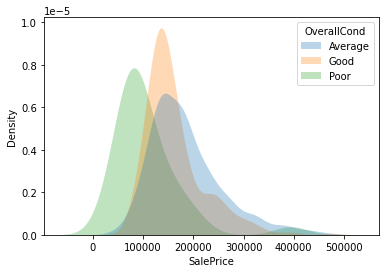

In [17]:
temp = train[['SalePrice','OverallCond']].copy()
temp['OverallCond'] = temp['OverallCond'].replace({
    1:'Poor',2:'Poor',3:'Poor',
    4:'Average',5:'Average',6:'Average',
    7:'Good',8:'Good',9:'Good',10:'Good'
})

sns.kdeplot(
   data=temp[temp.SalePrice < 500000], x="SalePrice", hue="OverallCond",
   fill=True, common_norm=False,alpha=.3, linewidth=0,
)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

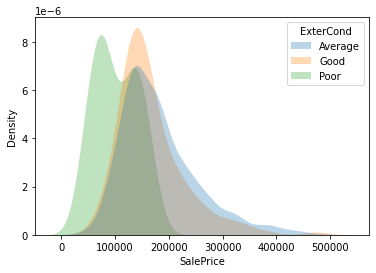

In [18]:
temp = df[['SalePrice','ExterCond']].copy()
temp['ExterCond'] = temp['ExterCond'].replace({
    1:'Poor',2:'Poor',3:'Average',4:'Good',5:'Good'
})

sns.kdeplot(
   data=temp[temp.SalePrice < 500000], x="SalePrice", hue="ExterCond",
   fill=True, common_norm=False,alpha=.3, linewidth=0,
)

### Date Variables

In [19]:
fig = px.scatter(df, x = 'YearBuilt', y = 'YearRemodAdd')
fig.show()

In [20]:
fig = px.scatter(df, x = 'YearBuilt', y = 'GarageYrBlt')
fig.show()

In [21]:
fig = px.box(df, x = 'YrSold', y = 'SalePrice')
fig.show()

In [22]:
fig = px.box(df, x = 'MoSold', y = 'SalePrice')
fig.show()

## Garage

In [23]:
columns = [x for x in train.columns if x.startswith('Garage')]
temp = df[df.GarageArea > 0][columns + ['SalePrice']].copy()

corr = temp[columns + ['SalePrice']].corr()
for col in corr.columns:
    corr.loc[col,col] = 0
    pass

fig = px.imshow(corr)
fig.show()

## Bathrooms

In [24]:
columns = [x for x in train.columns if 'Bath' in x]
temp = df[df.GarageArea > 0][columns + ['SalePrice']].copy()

corr = temp[columns + ['SalePrice']].corr()
for col in corr.columns:
    corr.loc[col,col] = 0
    pass

fig = px.imshow(corr)
fig.show()

## Misc Ordinal Variables

In [25]:
misc_ordinal = ['Street', 'Alley','LotShape','Utilities','LandSlope','Functional', 'Fence']

corr = df[misc_ordinal + ['SalePrice']].corr()
for col in corr.columns:
    #corr.loc[col,col] = 0
    pass

fig = px.imshow(corr)
fig.show()

## Nominal Features

In [26]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['MSSubClass']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['MSSubClass'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text="MSSubClass", showlegend = False)
fig.show()

In [27]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['MSZoning']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['MSZoning'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text="MSZoning", showlegend = False)
fig.show()

In [28]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['LandContour']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['LandContour'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='LandContour', showlegend = False)
fig.show()

In [29]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['LotConfig']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['LotConfig'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='LotConfig', showlegend = False)
fig.show()

In [30]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['Neighborhood']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['Neighborhood'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='Neighborhood', showlegend = False)
fig.show()

In [31]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['BldgType']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['BldgType'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='BldgType', showlegend = False)
fig.show()

In [32]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['HouseStyle']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['HouseStyle'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='HouseStyle', showlegend = False)
fig.show()

In [33]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['RoofStyle']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['RoofStyle'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='RoofStyle', showlegend = False)
fig.show()

In [34]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['RoofMatl']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['RoofMatl'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='RoofMatl', showlegend = False)
fig.show()

In [35]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['MasVnrType']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['MasVnrType'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='MasVnrType', showlegend = False)
fig.show()

In [36]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['Foundation']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['Foundation'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='Foundation', showlegend = False)
fig.show()

In [37]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['Heating']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['Heating'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='Heating', showlegend = False)
fig.show()

In [38]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = train['CentralAir']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=train['CentralAir'], y=train['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='CentralAir', showlegend = False)
fig.show()

In [39]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['Electrical']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['Electrical'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='Electrical', showlegend = False)
fig.show()

In [40]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['SaleType']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['SaleType'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='SaleType', showlegend = False)
fig.show()

In [41]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = df['SaleCondition']),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=df['SaleCondition'], y=df['SalePrice']),
    row=1, col=2
)

fig.update_xaxes(categoryorder = 'total descending')
fig.update_layout(title_text='SaleCondition', showlegend = False)
fig.show()